In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-8p4hkn2t
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-8p4hkn2t
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 17.85 MiB/s, done.


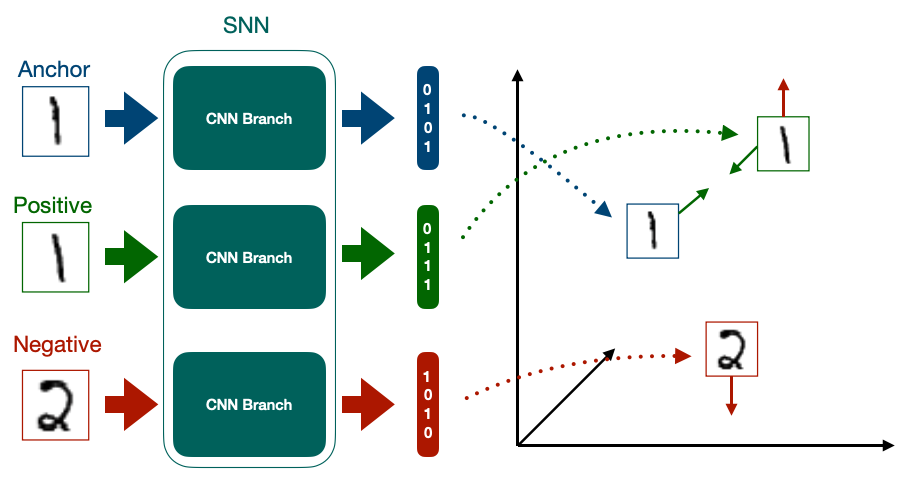

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 5

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR+row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR+row.Negative)

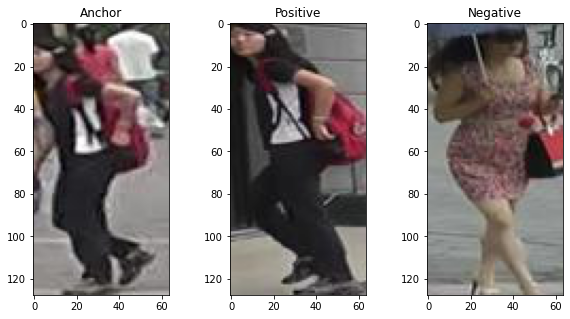

In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset 

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR+row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR+row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(len(trainset ), len(validset))

3200 800


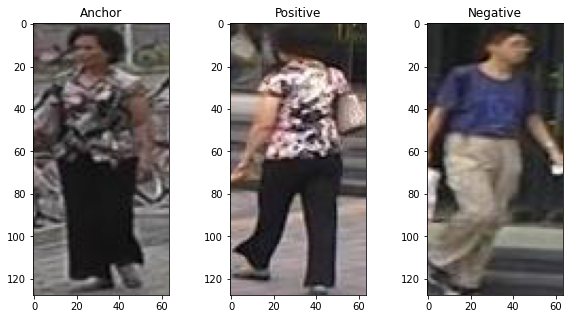

In [ ]:
idx = 42
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()

  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):

  model.train()

  total_loss = 0.0

  with torch.no_grad():

    for A, P, N in tqdm(dataloader):
      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_val_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_val_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_val_loss = valid_loss
    print("Saved Weights")

  print("Epochs", i+1, "train loss: ", train_loss, "valid loss:", valid_loss)

100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Saved Weights
Epochs 1 train loss:  0.12803383946418762 valid loss: 0.18294467508792878


100%|██████████| 25/25 [00:03<00:00,  7.96it/s]


Epochs 2 train loss:  0.11758924990892411 valid loss: 0.27164586663246154


100%|██████████| 25/25 [00:04<00:00,  5.22it/s]


Epochs 3 train loss:  0.11223908066749573 valid loss: 0.19668816149234772


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Saved Weights
Epochs 4 train loss:  0.08013558894395828 valid loss: 0.1816924750804901


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]

Saved Weights
Epochs 5 train loss:  0.044067378342151645 valid loss: 0.16849786400794983


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(anc_img_model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR+i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:42<00:00, 95.04it/s]


In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.399640,-0.124316,0.237746,-0.753380,0.278249,-0.020444,0.445764,0.154358,0.140114,...,-0.611408,-0.908461,-0.156239,0.523648,0.052169,0.550404,-0.038620,-0.728893,-0.189480,0.084790
1,1420_c3s3_061978_03.jpg,-0.504098,-0.388853,-0.025650,-1.228908,0.369822,-0.227905,0.679270,0.089009,-0.264968,...,-0.131407,-1.100630,-0.506297,0.482090,0.205522,-0.012809,0.262129,-0.351977,0.330157,0.620295
2,1420_c5s3_062565_05.jpg,-0.353661,-0.334119,0.211448,-0.870761,0.194880,-0.040135,0.390954,0.253873,-0.067311,...,-0.576442,-1.031804,-0.230144,0.646954,0.080571,0.325499,-0.055683,-0.546316,-0.098482,0.211769
3,1420_c6s3_085592_04.jpg,-0.215647,-0.156906,0.127224,-0.863802,0.119858,-0.015636,0.403862,0.228319,-0.291283,...,-0.446964,-0.551118,-0.228290,0.615434,-0.197759,0.763721,0.207041,-0.656514,-0.228228,-0.253199
4,0663_c5s3_085987_03.jpg,0.616447,0.006652,0.133397,1.530736,-0.602675,-0.102757,-1.227534,0.138222,-0.355113,...,0.327773,0.472940,0.582743,-0.300012,-0.228530,0.356419,-0.101260,0.621325,-0.265742,-0.971581


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img= img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.ilo[:,1:].to_Numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);